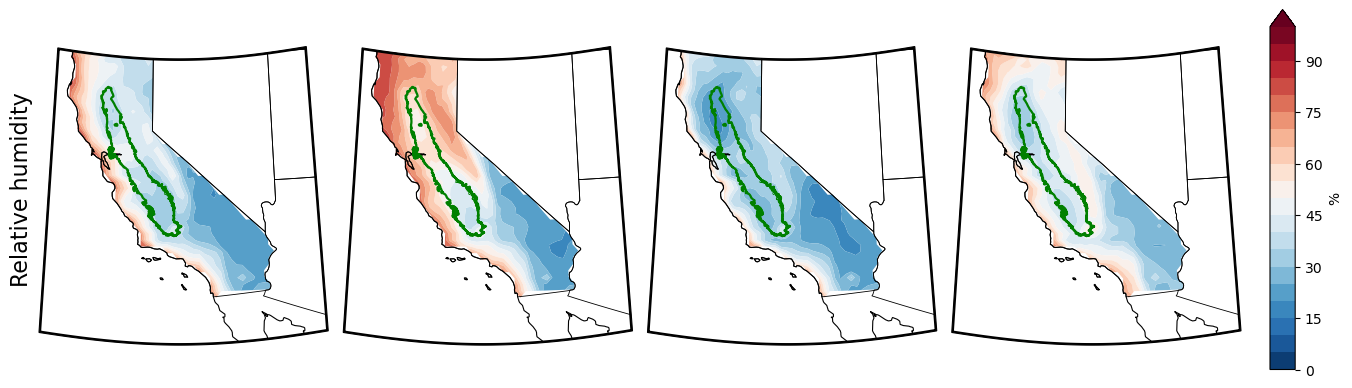

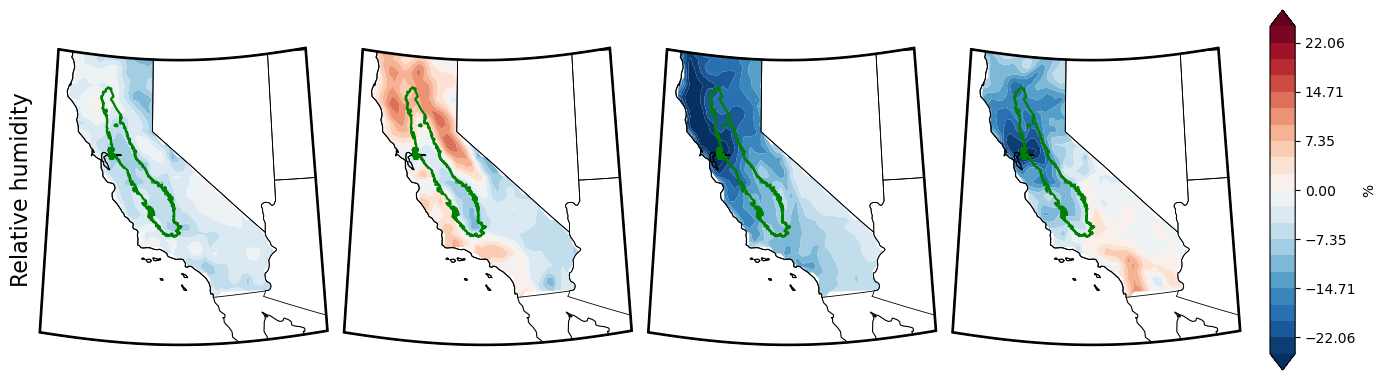

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu
import regionmask

# ======================= User inputs =======================
Z500_FILE     = "z_dust1.nc"
RH_COMP_FILE  = "son_rh_dusty.nc"
RH_CLIM_FILE  = "clim_rh.nc"
CV_SHP        = "central_valley_alluvial_boundary_usgs.shp"

OUT_MEAN      = "node_rh_mean.png"
OUT_ANOM      = "node_rh_anom.png"

LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# ======================= Helpers ===========================
def first_var(ds):
    for k in ["rh", "r", "hurs", "relative_humidity", "tcc"]:
        if k in ds.data_vars:
            return k
    return list(ds.data_vars)[0]

def detect_time(ds):
    for t in ["date", "time"]:
        if t in ds.coords or t in ds.dims:
            return t
    raise KeyError("No 'valid_time' or 'time' coordinate found.")

def rename_latlon(da):
    ren = {}
    if "lat" in da.dims: ren["lat"] = "latitude"
    if "lon" in da.dims: ren["lon"] = "longitude"
    return da.rename(ren) if ren else da

def fix_lon_range(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude + 180) % 360) - 180).sortby("longitude")
    return da

def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# ======================= 1) Train SOM on Z500 =======================
ds_z  = xr.open_dataset(Z500_FILE)
t_z   = detect_time(ds_z)

z = ds_z["z"]
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

z_son = z.sel({t_z: ds_z[t_z].dt.month.isin([9, 10, 11])})
z_son = rename_latlon(fix_lon_range(z_son))
z_son = (z_son
         .where((z_son.latitude  >= LAT0) & (z_son.latitude  <= LAT1), drop=True)
         .where((z_son.longitude >= LON0) & (z_son.longitude <= LON1), drop=True))

data  = z_son.values
ntime, nlat, nlon = data.shape
flat   = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]          # 0..3
times_all  = z_son[t_z].values
freqs      = np.array([(labels_all == n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs)

# ======================= 2) Load RH + climatology =======================
ds_rh_c  = xr.open_dataset(RH_COMP_FILE)
ds_rh_cl = xr.open_dataset(RH_CLIM_FILE)

VR = first_var(ds_rh_c)
VC = first_var(ds_rh_cl)

rh_comp = rename_latlon(fix_lon_range(ds_rh_c[VR]))
rh_clim = rename_latlon(fix_lon_range(ds_rh_cl[VC]))

t_rh = detect_time(ds_rh_c)
rh_comp = rh_comp.transpose(t_rh, "latitude", "longitude")
rh_clim = rh_clim.transpose("time", "latitude", "longitude")

rh_clim, rh_comp = xr.align(rh_clim, rh_comp, join="inner")

t_rh_vals = rh_comp[t_rh].values
_, idx_rh, idx_z = np.intersect1d(t_rh_vals, times_all, return_indices=True)
if idx_rh.size == 0:
    raise RuntimeError("No overlapping timestamps between RH composites and Z500 labels.")
rh_comp = rh_comp.isel({t_rh: idx_rh})
labels  = labels_all[idx_z]

md_rh   = rh_comp[t_rh].dt.strftime("%m-%d").values

md_coord = xr.DataArray(
    rh_clim["time"].dt.strftime("%m-%d").values,
    dims=["time"],
    name="md"
)
clim_by_md = rh_clim.groupby(md_coord).mean("time")  # dim 'md'

# ======================= 3) Per-node composites =======================
node_mean = {}
node_anom = {}

for n in range(4):
    sel = (labels == n)
    if not sel.any():
        proto = rh_comp.isel({t_rh: 0}).drop_vars(t_rh)
        node_mean[n] = xr.full_like(proto, np.nan)
        node_anom[n] = xr.full_like(proto, np.nan)
        continue

    rh_n  = rh_comp.isel({t_rh: sel})
    md_n  = md_rh[sel]

    mean_n = rh_n.mean(dim=t_rh, skipna=True)
    clim_mean_n = clim_by_md.sel(md=md_n).mean(dim="md", skipna=True)
    anom_n = mean_n - clim_mean_n

    # Convert to % if RH stored in 0–1
    if (float(mean_n.min()) >= 0 and float(mean_n.max()) <= 1 and
        float(clim_mean_n.min()) >= 0 and float(clim_mean_n.max()) <= 1):
        anom_n = anom_n * 100.0
        anom_n.attrs["units"] = "%"

    node_mean[n] = mean_n
    node_anom[n] = anom_n

mean_sorted = [node_mean[i] for i in order]
anom_sorted = [node_anom[i] for i in order]
freq_sorted = [freqs[i]     for i in order]

# ======================= 4) Optional: mask to California =======================
def mask_to_california(da):
    ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                        name="admin_1_states_provinces")
    states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
    ca_poly = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry.union_all()
    ca_gdf = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")
    mask = regionmask.mask_geopandas(ca_gdf, da.longitude, da.latitude)
    return da.where(~np.isnan(mask))

mean_sorted = [mask_to_california(da) for da in mean_sorted]
anom_sorted = [mask_to_california(da) for da in anom_sorted]

cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)

# ======================= 5) Plotters (NaN visual fix + 0–100 means, extend='max') =======================
def plot_fields(fields, title, out_png, units_label):
    proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                                 standard_parallels=(33,45))
    box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)

    fig, axes = plt.subplots(1, 4, figsize=(14,6), subplot_kw={"projection": proj})
    plt.tight_layout(rect=[0.06, 0.0, 0.94, 1.0])

    is_anom = ("anom" in out_png)
    cmap = mpl.colormaps["RdBu_r"].copy() if is_anom else mpl.colormaps["RdBu_r"].copy()

    if is_anom:
        arr = np.stack([f.values for f in fields], axis=0)
        rob  = np.nanpercentile(np.abs(arr), 98)
        vlim = max(float(rob), 1.0)
        levels = np.linspace(-vlim, vlim, 21)
        extend = "both"
        cmap.set_bad(cmap(0))
        cmap.set_under(cmap(0))
        #cmap.set_over(cmap(-1))
    else:
        # Force 0–100% and extend on the max side as requested
        levels = np.linspace(0.0, 100.0, 21)
        extend = "max"
        cmap.set_bad(cmap(0))      # NaNs = lowest color
        cmap.set_under(cmap(0))    # <0 (unlikely) = lowest color
        #cmap.set_over(cmap(-1))    # >100 = highest color

    lon2d, lat2d = np.meshgrid(fields[0].longitude, fields[0].latitude)
    cf_last = None
    for i, ax in enumerate(axes):
        clip_to_path(ax, box_path, linewidth=3)
        ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

        field = np.ma.masked_invalid(fields[i].values)  # apply set_bad/under/over
        cf_last = ax.contourf(lon2d, lat2d, field, levels=levels,
                              transform=ccrs.PlateCarree(),
                              cmap=cmap, extend=extend, antialiased=True)

        ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
        ax.add_feature(cfeature.STATES.with_scale("50m"),  linewidth=0.6, zorder=6)
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
        #ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=16, pad=3)

    try:
        fig.supylabel(title, x=0.05, fontsize=16)
    except Exception:
        fig.text(0.08, 0.5, title, rotation=90, va="center", ha="center", fontsize=14)

    cax = fig.add_axes([0.95, 0.20, 0.018, 0.60])
    cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
    cb.set_label(units_label)
    fig.savefig(out_png, dpi=500, bbox_inches="tight")
    plt.show()

# Plot mean & anomaly (frequency-ordered)
plot_fields(mean_sorted, "Relative humidity", OUT_MEAN,
            units_label=mean_sorted[0].attrs.get("units","%"))
plot_fields(anom_sorted, "Relative humidity", OUT_ANOM,
            units_label=anom_sorted[0].attrs.get("units","%"))


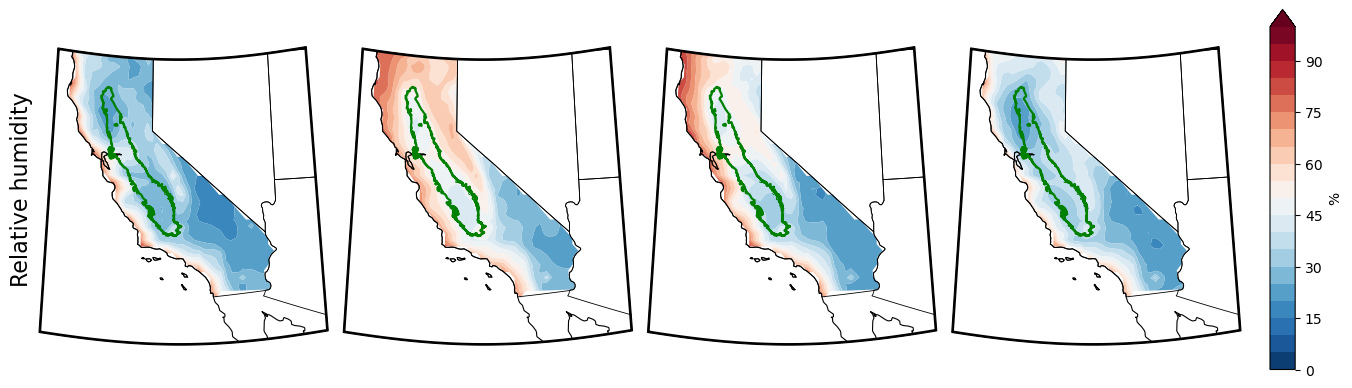

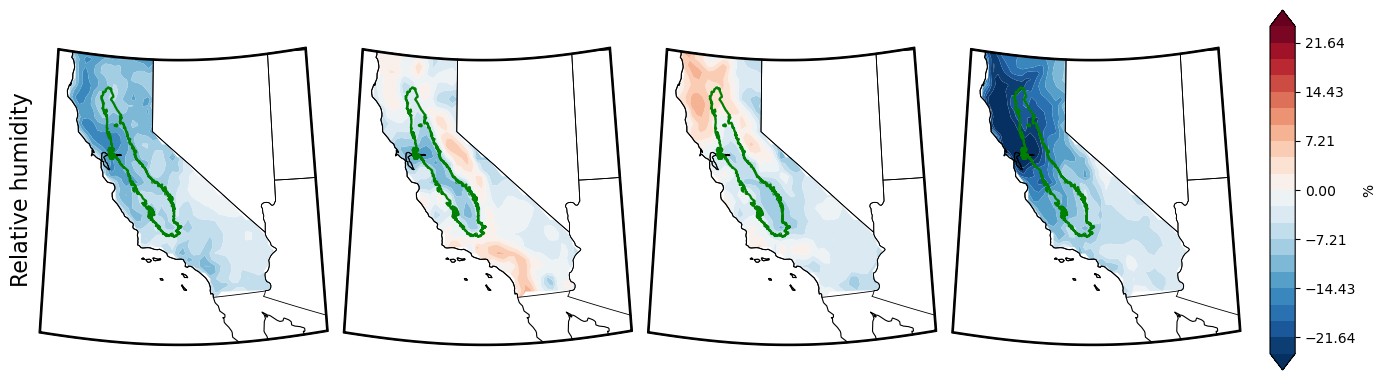

In [7]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu
import regionmask

# ======================= User inputs =======================
Z500_FILE     = "z_dust1.nc"
RH_COMP_FILE  = "ason_rh_dusty.nc"
RH_CLIM_FILE  = "ason_clim_rh.nc"
CV_SHP        = "central_valley_alluvial_boundary_usgs.shp"

OUT_MEAN      = "ason_node_rh_mean.png"
OUT_ANOM      = "ason_node_rh_anom.png"

LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# ======================= Helpers ===========================
def first_var(ds):
    for k in ["rh", "r", "hurs", "relative_humidity", "tcc"]:
        if k in ds.data_vars:
            return k
    return list(ds.data_vars)[0]

def detect_time(ds):
    for t in ["date", "time"]:
        if t in ds.coords or t in ds.dims:
            return t
    raise KeyError("No 'valid_time' or 'time' coordinate found.")

def rename_latlon(da):
    ren = {}
    if "lat" in da.dims: ren["lat"] = "latitude"
    if "lon" in da.dims: ren["lon"] = "longitude"
    return da.rename(ren) if ren else da

def fix_lon_range(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude + 180) % 360) - 180).sortby("longitude")
    return da

def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

# ======================= 1) Train SOM on Z500 =======================
ds_z  = xr.open_dataset(Z500_FILE)
t_z   = detect_time(ds_z)

z = ds_z["z"]
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

z_son = z.sel({t_z: ds_z[t_z].dt.month.isin([8,9, 10, 11])})
z_son = rename_latlon(fix_lon_range(z_son))
z_son = (z_son
         .where((z_son.latitude  >= LAT0) & (z_son.latitude  <= LAT1), drop=True)
         .where((z_son.longitude >= LON0) & (z_son.longitude <= LON1), drop=True))

data  = z_son.values
ntime, nlat, nlon = data.shape
flat   = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]          # 0..3
times_all  = z_son[t_z].values
freqs      = np.array([(labels_all == n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs)

# ======================= 2) Load RH + climatology =======================
ds_rh_c  = xr.open_dataset(RH_COMP_FILE)
ds_rh_cl = xr.open_dataset(RH_CLIM_FILE)

VR = first_var(ds_rh_c)
VC = first_var(ds_rh_cl)

rh_comp = rename_latlon(fix_lon_range(ds_rh_c[VR]))
rh_clim = rename_latlon(fix_lon_range(ds_rh_cl[VC]))

t_rh = detect_time(ds_rh_c)
rh_comp = rh_comp.transpose(t_rh, "latitude", "longitude")
rh_clim = rh_clim.transpose("time", "latitude", "longitude")

rh_clim, rh_comp = xr.align(rh_clim, rh_comp, join="inner")

t_rh_vals = rh_comp[t_rh].values
_, idx_rh, idx_z = np.intersect1d(t_rh_vals, times_all, return_indices=True)
if idx_rh.size == 0:
    raise RuntimeError("No overlapping timestamps between RH composites and Z500 labels.")
rh_comp = rh_comp.isel({t_rh: idx_rh})
labels  = labels_all[idx_z]

md_rh   = rh_comp[t_rh].dt.strftime("%m-%d").values

md_coord = xr.DataArray(
    rh_clim["time"].dt.strftime("%m-%d").values,
    dims=["time"],
    name="md"
)
clim_by_md = rh_clim.groupby(md_coord).mean("time")  # dim 'md'

# ======================= 3) Per-node composites =======================
node_mean = {}
node_anom = {}

for n in range(4):
    sel = (labels == n)
    if not sel.any():
        proto = rh_comp.isel({t_rh: 0}).drop_vars(t_rh)
        node_mean[n] = xr.full_like(proto, np.nan)
        node_anom[n] = xr.full_like(proto, np.nan)
        continue

    rh_n  = rh_comp.isel({t_rh: sel})
    md_n  = md_rh[sel]

    mean_n = rh_n.mean(dim=t_rh, skipna=True)
    clim_mean_n = clim_by_md.sel(md=md_n).mean(dim="md", skipna=True)
    anom_n = mean_n - clim_mean_n

    # Convert to % if RH stored in 0–1
    if (float(mean_n.min()) >= 0 and float(mean_n.max()) <= 1 and
        float(clim_mean_n.min()) >= 0 and float(clim_mean_n.max()) <= 1):
        anom_n = anom_n * 100.0
        anom_n.attrs["units"] = "%"

    node_mean[n] = mean_n
    node_anom[n] = anom_n

mean_sorted = [node_mean[i] for i in order]
anom_sorted = [node_anom[i] for i in order]
freq_sorted = [freqs[i]     for i in order]

# ======================= 4) Optional: mask to California =======================
def mask_to_california(da):
    ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                        name="admin_1_states_provinces")
    states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
    ca_poly = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry.union_all()
    ca_gdf = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")
    mask = regionmask.mask_geopandas(ca_gdf, da.longitude, da.latitude)
    return da.where(~np.isnan(mask))

mean_sorted = [mask_to_california(da) for da in mean_sorted]
anom_sorted = [mask_to_california(da) for da in anom_sorted]

cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)

# ======================= 5) Plotters (NaN visual fix + 0–100 means, extend='max') =======================
def plot_fields(fields, title, out_png, units_label):
    proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                                 standard_parallels=(33,45))
    box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)

    fig, axes = plt.subplots(1, 4, figsize=(14,6), subplot_kw={"projection": proj})
    plt.tight_layout(rect=[0.06, 0.0, 0.94, 1.0])

    is_anom = ("anom" in out_png)
    cmap = mpl.colormaps["RdBu_r"].copy() if is_anom else mpl.colormaps["RdBu_r"].copy()

    if is_anom:
        arr = np.stack([f.values for f in fields], axis=0)
        rob  = np.nanpercentile(np.abs(arr), 98)
        vlim = max(float(rob), 1.0)
        levels = np.linspace(-vlim, vlim, 21)
        extend = "both"
        cmap.set_bad(cmap(0))
        cmap.set_under(cmap(0))
        #cmap.set_over(cmap(-1))
    else:
        # Force 0–100% and extend on the max side as requested
        levels = np.linspace(0.0, 100.0, 21)
        extend = "max"
        cmap.set_bad(cmap(0))      # NaNs = lowest color
        cmap.set_under(cmap(0))    # <0 (unlikely) = lowest color
        #cmap.set_over(cmap(-1))    # >100 = highest color

    lon2d, lat2d = np.meshgrid(fields[0].longitude, fields[0].latitude)
    cf_last = None
    for i, ax in enumerate(axes):
        clip_to_path(ax, box_path, linewidth=3)
        ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

        field = np.ma.masked_invalid(fields[i].values)  # apply set_bad/under/over
        cf_last = ax.contourf(lon2d, lat2d, field, levels=levels,
                              transform=ccrs.PlateCarree(),
                              cmap=cmap, extend=extend, antialiased=True)

        ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
        ax.add_feature(cfeature.STATES.with_scale("50m"),  linewidth=0.6, zorder=6)
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
        #ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=16, pad=3)

    try:
        fig.supylabel(title, x=0.05, fontsize=16)
    except Exception:
        fig.text(0.08, 0.5, title, rotation=90, va="center", ha="center", fontsize=14)

    cax = fig.add_axes([0.95, 0.20, 0.018, 0.60])
    cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
    cb.set_label(units_label)
    fig.savefig(out_png, dpi=500, bbox_inches="tight")
    plt.show()

# Plot mean & anomaly (frequency-ordered)
plot_fields(mean_sorted, "Relative humidity", OUT_MEAN,
            units_label=mean_sorted[0].attrs.get("units","%"))
plot_fields(anom_sorted, "Relative humidity", OUT_ANOM,
            units_label=anom_sorted[0].attrs.get("units","%"))
